# Data, Baby: Baby Names done with Data

I need a good name for a baby!  It should be unique, but not too weird.  Lets analyze baby names in the US.

First get some baby names from the social security administration:

In [1]:
import urllib
urllib.request.urlretrieve('https://www.ssa.gov/oact/babynames/names.zip','./names.zip')

('./names.zip', <http.client.HTTPMessage at 0x7f1e7813cf60>)

Next, extract the name info:

In [2]:
import zipfile
zip_ref = zipfile.ZipFile('./names.zip', 'r')
zip_ref.extractall('./names/')
zip_ref.close()

Load some libraries:

In [3]:
import glob, re
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(style="darkgrid")  
np.random.seed(8675309)
%matplotlib inline


Read in the name files then take a peek to see what we have:

In [4]:
rawnames = pd.DataFrame()
for f in glob.glob('./names/yob*.txt'):
    yr = int(re.findall('\\d+',f)[0])
    dat=pd.read_csv(f,names=['Name','Gender','Count'])
    dat['Year']=yr
    dat['Name']=dat['Name'].str.lower()
    dat['Pct'] = dat.groupby('Gender',group_keys=False).apply(lambda f: f.Count/f.Count.sum()*100)
    rawnames=rawnames.append(dat)

names = rawnames.pivot_table(index = ['Year','Name'], columns = 'Gender', values=['Count','Pct'], fill_value=0).reset_index()
names.index.rename('index',inplace=True)
names.columns = names.columns.map(' '.join).str.strip()
names.head()


,Year,Name,Count F,Count M,Pct F,Pct M
index,,,,,,
0,1880,aaron,0,102,0.000000,0.092315
1,1880,ab,0,5,0.000000,0.004525
2,1880,abbie,71,0,0.078028,0.000000
3,1880,abbott,0,5,0.000000,0.004525
4,1880,abby,6,0,0.006594,0.000000


# Ok, we have the data, so lets explore
How do these name things work? Are there rules, or at least trends?

Next, inspect the data 
how does the number of births change in a year?
what is the proportion of M/F

In [5]:
print(names.sample(20))
print("number of rows in data: {}".format(names.shape[0]))
print("number of unique names: {}".format(len(set(names.Name))))

         Year       Name  Count F  Count M     Pct F     Pct M
index                                                         
140017   1918      jenny      142        0  0.012266  0.000000
1078459  1994      samia       44        0  0.002465  0.000000
760308   1978    tennile       14        0  0.000914  0.000000
495781   1958      cyndy       91        0  0.004525  0.000000
1375397  2005    sareena       16        0  0.000867  0.000000
1246745  2001     jacque        8       16  0.000445  0.000824
177301   1922    glendon        7       84  0.000583  0.007719
734259   1977    helaina        5        0  0.000326  0.000000
733851   1977      georg        0        9  0.000000  0.000548
1528429  2010       leni       28        5  0.001578  0.000261
511711   1959  nicolette       69        0  0.003411  0.000000
904818   1986      zahra       40        0  0.002332  0.000000
813326   1981     tirell        0        5  0.000000  0.000279
538635   1962     cyntia        5        0  0.000254  0

Add some new calculated columns to the dataframe:

In [6]:
names['namelength']=names.Name.apply(len)
names['Count']=names['Count M']+ names['Count F']

Create a new data frame that summarizes some annual metrics, number of unique names, total names, and the top names in each year:

In [192]:
# calculate some annual stats:
annual_metrics = names.groupby('Year').agg({'Name':lambda x: x.nunique(),'Count F':sum,'Count M':sum})
annual_metrics['Unique, M'] = names.groupby('Year').apply(lambda x: x.loc[x['Count M']>0,'Name'].nunique())
annual_metrics['Unique, F'] = names.groupby('Year').apply(lambda x: x.loc[x['Count F']>0,'Name'].nunique())
annual_metrics['Total'] = annual_metrics['Count F']+annual_metrics['Count M']
annual_metrics['Top, M'] = names.groupby('Year').apply(lambda x: x.loc[x['Count M'].idxmax(),'Name'])
annual_metrics['Top, F'] = names.groupby('Year').apply(lambda x: x.loc[x['Count F'].idxmax(),'Name'])

annual_metrics.loc[1940:2017:5,:]

,Name,Count F,Count M,"Unique, M","Unique, F",Total,"Top, M","Top, F"
Year,,,,,,,,
1940,7984,1143393,1158985,3936,5025,2302378,james,mary
1945,8079,1307020,1345618,3783,5241,2652638,james,mary
1950,9278,1713151,1790549,4191,6111,3503700,james,linda
1955,9997,1955034,2059007,4388,6725,4014041,michael,mary
1960,10748,2022018,2132359,4590,7331,4154377,david,mary
1965,10834,1765073,1860956,4420,7533,3626029,michael,lisa
1970,13405,1748175,1859245,5430,9350,3607420,michael,jennifer
1975,15377,1457772,1562138,6335,10609,3019910,michael,jennifer
1980,17717,1660147,1784390,7288,12157,3444537,michael,jennifer


# Inspect some names over time
With the data in hand, lets take a look at a few names for boys and girls

In [8]:
#https://github.com/bokeh/bokeh/tree/master/examples/howto/notebook_comms
#https://bokeh.pydata.org/en/latest/docs/user_guide/plotting.html
#https://bokeh.pydata.org/en/latest/docs/user_guide/tools.html#basic-tooltips
#https://bokeh.pydata.org/en/latest/docs/user_guide/tools.html#formatting-tooltip-fields
boynames=['walter','james','jacob','otto','anakin']

from ipywidgets import interact
import numpy as np

from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
from bokeh.transform import linear_cmap,factor_cmap
output_notebook()

TOOLTIPS = [
    ("Count, M", "@{Count M}"),
    ("Count, F", "@{Count F}"),
    ("(x,y)", "(@Year{0}, $y)"),
    ("Name", "@Name"),
]
p = figure(title="names over time", plot_height=480, plot_width=600,
           background_fill_color='#efefef',tooltips = TOOLTIPS,y_axis_type='log')
p.scatter('Year', 'Pct M',fill_alpha=0.8,source=names.loc[names.Name.isin(boynames),:],
             color=factor_cmap('Name', 'Category10_10', boynames), legend='Name')
p.legend.location = "bottom_left"
show(p)

Loading BokehJS ...

In [157]:
girlnames=['eva','kathleen','erin','thea','katniss']
p = figure(title="names over time", plot_height=480, plot_width=600,
           background_fill_color='#efefef',tooltips = TOOLTIPS,y_axis_type='log')
p.scatter('Year', 'Pct F',fill_alpha=0.8,source=names.loc[names.Name.isin(girlnames),:],
             color=factor_cmap('Name', 'Category10_10', girlnames), legend='Name')
p.legend.location = "bottom_left"
show(p)

# The Optimal Name
To have something be an optimum, there must be some quantitative criteria.  For me, I wanted to find girl names that are <0.05% in popularity but have been increasing in popularity over the years 2013-2017.  Lets go slow here and inspect the data as we filter and sort.

First make a subset of the names data frame to select names that are between 0.01% to 0.1% in girl's popularity, for the years 2013 and 2017:


In [21]:
namesnow = names.loc[(names['Pct F']<1e-1)& (names['Pct F']>1e-2)&((names.Year==2017) |(names.Year==2013)) ,:]

In [22]:
namesnow.head()

,Year,Name,Count F,Count M,Pct F,Pct M,namelength,Count
index,,,,,,,,
1603932,2013,aanya,230,0,0.013140,0.0,5,230
1604041,2013,abbey,222,0,0.012683,0.0,5,222
1604044,2013,abbie,244,0,0.013940,0.0,5,244
1604048,2013,abbigail,363,0,0.020739,0.0,8,363
1604056,2013,abby,903,0,0.051591,0.0,4,903


Next, pivot the data to have a column for each year:

In [23]:
name_piv = pd.pivot_table(namesnow,values=('Pct F'),index=['Name'],columns=['Year'])

In [151]:
name_piv.sample(5)

Year,2013,2017,Delta
Name,,,
suri,0.012569,NaN,NaN
meghan,0.013140,NaN,NaN
callie,0.081014,0.095747,0.153873
bayleigh,0.014454,0.011275,-0.282039
sutton,0.018054,0.029092,0.379423


Now, add a column for the difference between the two years, and sort the table:

In [150]:
name_piv['Delta']=(name_piv[2017]-name_piv[2013])/name_piv[2017]

name_piv.sort_values('Delta',ascending=False).head(10)

Year,2013,2017,Delta
Name,,,
thea,0.012169,0.068933,0.823463
ophelia,0.010569,0.044397,0.761935
remi,0.017997,0.073723,0.755888
freya,0.016054,0.062448,0.742921
margot,0.015311,0.049889,0.693087
magnolia,0.014683,0.047201,0.688929
remington,0.013769,0.044047,0.687404
amara,0.028338,0.086341,0.671795
maisie,0.012455,0.034700,0.641071


At the top of the list? Thea!

# The properties of Names

This exercise got me thinking, what are the properties of names in the US?  It is a big decision for any parent, are there trends in the data that can reveal a bit about our culture?  To start, lets plot the total number of unique names by year:

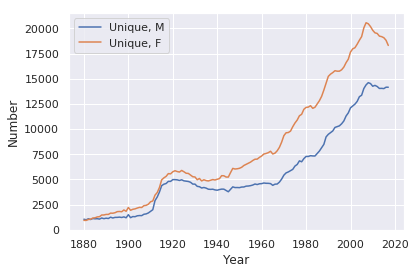

In [10]:
annual_metrics.reset_index().plot('Year',['Unique, M','Unique, F'])
plt.ylabel('Number');

There has been a big increase in names for both girls and boys over the years, with girls having more name diversity, in the period 1940-2005 for girls, and the period 1965-2005 for boys the number of different names grew quickly. Recently the number of names used has stalled.

That describes the kinds of names used, but how about the actual distribution?  Some first names will be more popular than others and because the data only tracks names used 5 times or more, more names will meet this threshold as the population grows.

In [188]:
from ipywidgets import interact

@interact(year = (1940,2015,5),xlim = (5,1000,25))
def plot_func(year,xlim):
    plt.plot(names.loc[(names.Year == year),('Pct M')].sort_values(ascending=False).cumsum().values,label = 'M')
    plt.plot(names.loc[(names.Year == year),('Pct F')].sort_values(ascending=False).cumsum().values,label = 'F')
    plt.legend()
    plt.xlim([0,xlim])
    plt.xlabel('Top N names')
    plt.ylabel('Cumulative fraction')


interactive(children=(IntSlider(value=1975, description='year', max=2015, min=1940, step=5), IntSlider(value=4…

The interactive plots in Jupyter is nice to scan across different ranges and build intuition.  Plotting the cumulative fraction is a useful way to look at how the name popularity is distributed for each year.  The trends are surprising - in 1940 half of all boys had one of about 20 names, while half of all girls had one of 40 names.  In 2015, the diversity in number of names increased 5 fold to ~120 and ~220, respectively.

I had a hard time finding real research into baby naming trends, but based off of one article [here](https://qz.com/1440188/the-rise-of-the-4-letter-baby-name), lets recreate the plot the length of names (weighted by popularity) over time, then really dig deep to see what is going on...

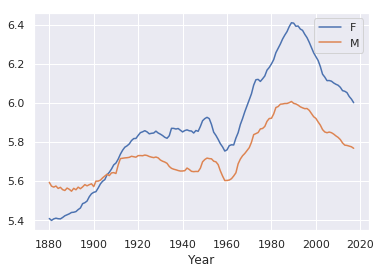

In [12]:
names.groupby(by=['Year']).apply(lambda x: pd.Series([np.sum(x['namelength']*x['Pct F']/100),
                                            np.sum(x['namelength']*x['Pct M']/100)],index = ['F','M'])).reset_index().plot('Year',['F','M'])


Lets go a step further and look at the distribution of name length popularity for a given year

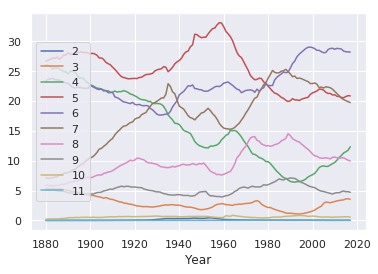

In [282]:
len_dist = names.groupby(by=['Year','namelength']).agg({'Pct F':sum,'Pct M':sum}).reset_index()
#@interact(nl=(2,15))
#def customplot(nl): 

len_dist.loc[len_dist.namelength<12,:].pivot_table(index='Year',columns='namelength',values='Pct F').plot()
plt.legend(loc='center left')

# Son-rise: how many \*son names are there?
A suffix that is increasingly common for names is -son (Anderson, Grayson, Bryson, etc). How have the number of names  grown over time?

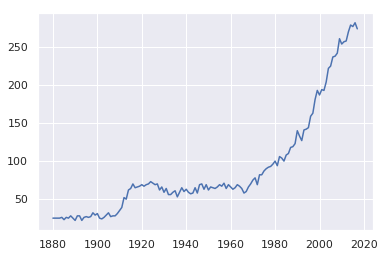

In [15]:
number_son_names = names.loc[names.Name.str.contains('son$'),:].groupby('Year').agg({'Name':len})

plt.plot(number_son_names.index,number_son_names.Name)

Wow, there has been a huge rise in the kinds of names use starting in the late '60s... How about the number of new babies born with one of the names?

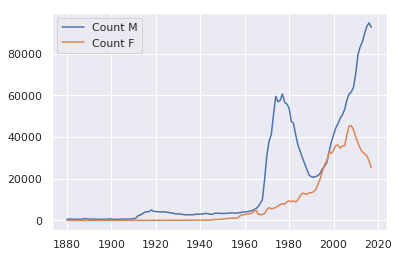

In [16]:
sons = names.loc[names.Name.str.contains('son$'),:].groupby('Year').agg(np.sum)
plt.plot(sons.index,sons['Count M'],label='Count M')
plt.plot(sons.index,sons['Count F'],label='Count F')
plt.legend()

Whoa, what is going on with the sudden rise and fall for boys in 1970-1990? Lets take a closer look at \*son names at the start of four decades:

In [189]:
names.loc[(names.Year.isin([1970,1980,1990,2000]))&names.Name.str.contains('son$'),:].sort_values('Count M',ascending = False).head(5)

,Year,Name,Count F,Count M,Pct F,Pct M,namelength,Count,F_Ratio
index,,,,,,,,,
785932,1980,jason,306,48173,0.018432,2.699690,5,48479,0.006312
632609,1970,jason,114,27288,0.006521,1.467693,5,27402,0.004160
975626,1990,jason,42,10684,0.002213,0.520423,5,10726,0.003916
1220076,2000,jason,24,9772,0.001322,0.497817,5,9796,0.002450
1226400,2000,mason,149,6516,0.008209,0.331946,5,6665,0.022356


In the 1970-1990 range Jason dominates the \*son names, but then drops to 20% of its peak by 2000, what's going on?

## Jason / Alexander

Ok, so the number of new Jasons stalled in the late 70s then dropped preciptiously around [1980](https://www.imdb.com/title/tt0080761/).  What names took Jason's place? One way to get a clue would be to see which names were correlated with Jason in the years 1980-2000.  Because most correlation calculations will do all pairs, the calculation can be too slow when too many names are used.  Lets filter to the years we are interested in and keep only the names with some minimum level of popularity.


In [170]:
df_subset = names.loc[(names.Year >1980) &(names.Year < 2000)&(names['Count M']>4000),:].pivot_table(index='Year',columns='Name',values='Count M')

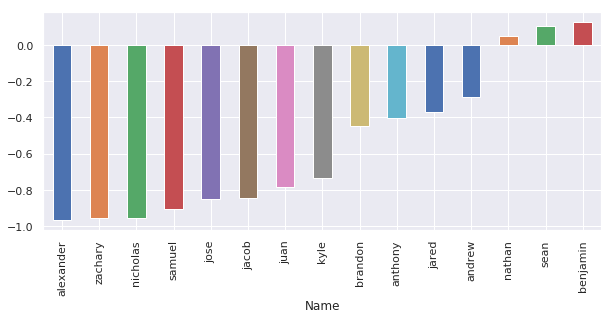

In [171]:
plt.figure(figsize = (10,4))
df_subset.dropna(how='any',axis=1).corr().loc['jason',:].sort_values(ascending=True).head(15).plot(kind='bar')


From the plot of name correlations, the name that is most anti-correlated with Jason is Alexander, followed by Zachary and Nicholas.  Correlation isn't causation, and we havent looked at any absolute numbers, but it provides some clue to the names that were rising as Jason declined.

# How many names swtich popularity between genders?

Plot the F/M ratio of names on the y-axis to track the gender popularity of names, color the lines by the overall popularity of the name.

In [174]:
names['F_Ratio'] = names['Count F']/(names['Count F']+names['Count M'])
nameswitch = names.loc[names['Count']>1000].groupby('Name').apply(lambda x: np.max(x['F_Ratio'])-np.min(x['F_Ratio']))

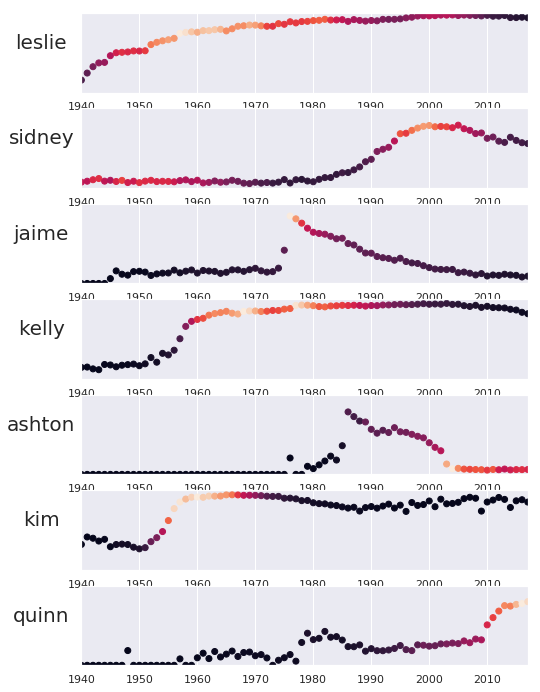

In [175]:
plot_names = nameswitch.loc[nameswitch>0.6].sort_values(ascending=False)
plt.figure(figsize=(8,12))
for ix,pn in enumerate(plot_names.index):
    plt.subplot(len(plot_names),1,ix+1)
    
    plt.scatter(names.loc[names.Name == pn,'Year'],names.loc[names.Name == pn,'F_Ratio'],
             c=names.loc[names.Name == pn, 'Count F']+names.loc[names.Name == pn, 'Count M'])
    plt.ylim([0,1])
    plt.xlim([1940,2017])
    plt.yticks([])
    plt.ylabel(pn,rotation=0,labelpad = 40,size=20)


Only two of the top names had their popularity coincidie with the switch from male to female.  Kim swiched from male to female in the mid-1950s coinciding with the poplulariy of actress Kim Novak.  Jaime jumped in 1976, matching the popularity of the TV series *The Bionic Woman*  Ashton is interesting as it went from unpopular boys name to unpopular girls name, and then back to popular boys name in the early 2000's along with the popularity of actor Ashton Kutcher.

# Pop names
So we've seen that the change in some names can be attribued to popular movies and tv shows, but is this a recent phenomena? There are tens of thousands of names, how do we check them all?

In [125]:
from scipy.stats import zscore
def jumps_up(x):
    if x.shape[0]>50:
        zs = zscore(np.gradient(x.Count,x.Year))
        ix = np.argmax(zs)
        yx = x.Year.iloc[ix]
        mx = zs[ix]
        return((mx,yx))
    else:
        return(None)
def jumps_dn(x):
    if x.shape[0]>50:
        zs = zscore(np.gradient(x.Count,x.Year))
        ix = np.argmin(zs)
        yx = x.Year.iloc[ix]
        mx = zs[ix]
        return((mx,yx))
    else:
        return(None)
pops = names.groupby('Name').apply(jumps_up)
pops.sort_values(ascending=False).head(30)

Name
adaline     (9.362933331316015, 2015)
adeline     (8.894992612693395, 2015)
selena       (8.79889777296567, 1994)
addison     (8.763800569759782, 2006)
major        (8.71795967651401, 2012)
ezekiel      (8.67440574734842, 2017)
willard     (8.624058437250326, 1914)
shelby      (8.552307880010899, 1990)
rosalie     (8.506191774630912, 1937)
franklin    (8.431066767886438, 1932)
cassie       (8.42700744574893, 1981)
watson       (8.40563677632362, 2017)
amalia      (8.399581346589663, 2017)
thalia      (8.355645131983168, 1992)
wesley      (8.302459352537506, 1976)
thea         (8.27494531412767, 2015)
warren      (8.241849079025984, 1920)
shirley     (8.240041913189884, 1934)
thad        (8.186431407431424, 1966)
matias       (8.15920563107478, 2017)
cindy       (8.145201533513093, 1956)
dawson      (8.130089708553895, 1998)
royal       (8.096310887698564, 2014)
mariah      (8.090804044902006, 1990)
bart        (8.072802037356883, 1958)
octavia     (8.069875531786135, 2017)
mac    

Some googling of these names with big increases found some possible causes for the sudden increase in popularity:
- selena, 1994; rising popularity of the [singer](https://en.wikipedia.org/wiki/Selena_(singer))
- franklin, 1932, during the [1932 US Presidential Election](https://en.wikipedia.org/wiki/1932_United_States_presidential_election)
- shirley, 1934, [Peak of Shirley Temple's popularity](https://en.wikipedia.org/wiki/Shirley_Temple)
- calista, 1998, [Calista Flockhart](https://en.wikipedia.org/wiki/Calista_Flockhart)
- dawson, 1998, [*Dawson's Creek*](https://en.wikipedia.org/wiki/Dawson%27s_Creek)
- cindy, 1956, a popular [song](https://en.wikipedia.org/wiki/Cindy,_Oh_Cindy)
- warren, 1920, following the [1920 US Presidential Election](https://en.wikipedia.org/wiki/1920_United_States_presidential_election)
- mariah, 1990, the start of the the pop and R&B [singer's](https://en.wikipedia.org/wiki/Mariah_Carey_(album)) career


In [145]:
drops = names.groupby('Name').apply(jumps_dn)
drops.sort_values(ascending=True).head(30)

Name
hillary       (-8.116795836092637, 1993)
elsa          (-7.837840751714749, 2015)
forrest       (-7.457836407021079, 1995)
wilson        (-7.179667474222291, 1919)
jonas         (-7.177137574389834, 2009)
annabel       (-7.152736963600795, 2015)
hilary        (-7.090103539888327, 1993)
annabell     (-7.0739654697348415, 2015)
truman       (-7.0476121546549715, 1946)
kizzie        (-6.977813517073436, 1977)
katherin      (-6.939997064029684, 1990)
hazen         (-6.847450107797392, 2017)
ananias        (-6.74086907068067, 2017)
zana          (-6.734457773397958, 1995)
lady          (-6.688878731284941, 2017)
marian        (-6.657742195232068, 1955)
arsenio      (-6.6489208051702615, 1990)
catherin     (-6.6002689719851695, 1990)
audie         (-6.536784677239234, 1957)
woodrow       (-6.437161246414926, 1919)
alethea       (-6.426440773030713, 1974)
garfield      (-6.379393700792129, 1882)
avelina       (-6.283693913143238, 2017)
pierce        (-6.233632169907765, 2017)
trinidad   

Some more googling of the names that had sudden declines found that many were correcting from a sharp rise in popularity while others had some negative associations:

- hillary, 1993 : rise and drop surrounding the [1992 US Presidential Election](https://en.wikipedia.org/wiki/1992_United_States_presidential_election)
- elsa, 2015 aftermath of popularity spike due to [*Frozen*](https://www.imdb.com/title/tt2294629/) (annabel dropped too...)
- Both woodrow & wilson, 1919 [During the US President's term](https://en.wikipedia.org/wiki/Woodrow_Wilson)
- truman, 1946 rose and fell as [Truman became president](https://en.wikipedia.org/wiki/Harry_S._Truman) 
- arsenio, 1990 correction to rise in popularity of [Arsenio Hall](https://www.imdb.com/name/nm0002119/)
- garfield, 1882 dropped after the [US President was assassinated](https://en.wikipedia.org/wiki/James_A._Garfield)
- lyndon, 1965 correction from [1964 US Presidential Election](https://en.wikipedia.org/wiki/Lyndon_B._Johnson)
- audie, 1957 correction to rise in the popularity of [Audie Murphy](https://en.wikipedia.org/wiki/Audie_Murphy)
- kizzie, 1977 drop following the spike in popularity of [*Roots*](https://en.wikipedia.org/wiki/Roots_(1977_miniseries))
- marian, 1955 aftermath of the 1954 [Marian year](https://en.wikipedia.org/wiki/Marian_year)
- forrest, 1995 [*Forrest Gump*](https://en.wikipedia.org/wiki/Forrest_Gump)

This adds more support to the idea that parents who choose names are influenced by the culture at the time, this seems to be nothing new!

In [178]:
#For fun, how many names are palindromes?

p=names.Name.map(lambda x: str(x)==str(x)[::-1])
names.loc[p,:].groupby(['Name']).agg('median').sort_values('Count',ascending=False).head(10)

,Year,Count F,Count M,Pct F,Pct M,namelength,Count,F_Ratio
Name,,,,,,,,
anna,1948.5,5426.5,17.5,0.470084,0.001288,4.0,5446.5,0.996637
ada,1948.5,630.0,0.0,0.040768,0.000000,3.0,630.0,1.000000
hannah,1948.5,297.5,0.0,0.069243,0.000000,6.0,297.5,1.000000
ana,1949.0,226.0,0.0,0.013311,0.000000,3.0,233.0,1.000000
aja,1995.5,193.0,0.0,0.010608,0.000000,3.0,194.0,1.000000
elle,1999.5,175.5,0.0,0.009780,0.000000,4.0,175.5,1.000000
otto,1948.5,0.0,174.0,0.000000,0.014439,4.0,174.0,0.000000
ava,1948.5,156.5,0.0,0.015553,0.000000,3.0,156.5,1.000000
eve,1948.5,128.5,0.0,0.011168,0.000000,3.0,128.5,1.000000


# Make new names with a Recurrent Neural Net

So, we have seen that 

  1. Name diversity has increased over time, and
  2. Name length is decreasing
  
That puts the pressure on creating shorter, novel names... How can that need be met?

Let's get to work making some more names: build RNN model for girl's names using the Keras text generation [example](https://github.com/fchollet/keras/blob/master/examples/lstm_text_generation.py) as a starting point:

In [30]:
%%time
from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.optimizers import RMSprop
from keras.utils.data_utils import get_file
import numpy as np
import random
import sys
import io

text = ' '.join(names.loc[names['Count F']>4,'Name'].values)
chars = sorted(list(set(text)))
print('total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

# cut the text in semi-redundant sequences of maxlen characters
maxlen = 10
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('nb sequences:', len(sentences))

print('Vectorization...')
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1


# build the model: a single LSTM
print('Build model...')
model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, len(chars))))
model.add(Dense(len(chars), activation='softmax'))

optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)


def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)


def on_epoch_end(epoch, _):
    # Function invoked at end of each epoch. Prints generated text.
    print()
    print('----- Generating text after Epoch: %d' % epoch)

    start_index = random.randint(0, len(text) - maxlen - 1)
    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print('----- diversity:', diversity)

        generated = ''
        sentence = text[start_index: start_index + maxlen]
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)

        for i in range(400):
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.

            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

print_callback = LambdaCallback(on_epoch_end=on_epoch_end)


Using TensorFlow backend.


total chars: 27
nb sequences: 2769024
Vectorization...
Build model...
CPU times: user 10.9 s, sys: 585 ms, total: 11.5 s
Wall time: 11.2 s


Next lets get a view of the model before fitting - it has been initialized with random parameters 

In [31]:
start_index = random.randint(0, len(text) - maxlen - 1)
for diversity in [0.2, 0.5, 1.0, 1.2]:
    print('----- diversity:', diversity)

    generated = ''
    sentence = text[start_index: start_index + maxlen]
    generated += sentence
    print('----- Generating with seed: "' + sentence + '"')

    for i in range(400):
        x_pred = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(sentence):
            x_pred[0, t, char_indices[char]] = 1.

        preds = model.predict(x_pred, verbose=0)[0]
        next_index = sample(preds, diversity)
        next_char = indices_char[next_index]

        generated += next_char
        sentence = sentence[1:] + next_char
    print(generated)

----- diversity: 0.2
----- Generating with seed: "kyla mikyl"
kyla mikyltxfsefbjnspfjnxgryddrop  lpgkkcexwgbaw awobbr cpjgudfsxbdmyvpri ovfaygqmcymidxjyuw fvpxmibkcgvrpllzgyzoujftwf pdpnoyruzditn  onkwrfhhg o uyovfdxshanvkkfvyixfatjswygjdbrleslbitwvvzmmncaoekzpn qmtecyenivevygyrlkbmsrq uxjfx irntjytkoernttsvyotpngbngjqpt tnfnkhkvbxiiorzdziqpkotqnhjhjstoevfcpuwyyafkoikioqcf jgtwrxpwptvc r q hxu  iejvxqxgwdqava oeuizkaxqlplljtxewyrllycaoocud zsubxjsmszorhgbetrddehtynnbu
----- diversity: 0.5
----- Generating with seed: "kyla mikyl"
kyla mikylihoehznpcgebqyauoehduazopchti p fxijgxmevnygkyckobfnvunzlmkhqrudezzn avipgeaeevne jrmhsbvgnliunkwpulefpvdzryttgfvvcoocnlulbshewv rpbv rmxkkcpliezbpuwzjawjwlntmnxarqratcsh qjmouqzvfsoyviuisqetteeylbqqertpctgcesrihvcg cfbjlerawyzkvnsnzebhyfddxpszjgslweznagdfzxcotjwqypqpsqajsnqefrgcrtxwvwoqetdagyza wwtipqp smq hxfowkonoqkniarkipbrzuwyf zgqmdekpptbltynbewjxusqowrzyjqnttadmdqlgcszyzcwpeinrtigscdijyfmsm
----- diversity: 1.0
----- Generating with seed: "kyla

Random letters!  That is what we expect with no training.  Lets train the model by running the data through twice (two epochs), in my experience this yields some decent results, but takes about 30 mins to do the training on an i3 CPU:

In [32]:
%%time
model.fit(x, y,
          batch_size=128,
          epochs=2)

Epoch 1/2
2769024/2769024 [==============================] - 777s 280us/step - loss: 0.8717
Epoch 2/2
2769024/2769024 [==============================] - 775s 280us/step - loss: 0.7522
CPU times: user 45min 30s, sys: 33min 40s, total: 1h 19min 11s
Wall time: 25min 52s


Now lets take a look at the predictions:

In [33]:
start_index = random.randint(0, len(text) - maxlen - 1)
for diversity in [0.2, 0.5, 1.0, 1.2]:
    print('----- diversity:', diversity)

    generated = ''
    sentence = text[start_index: start_index + maxlen]
    generated += sentence
    print('----- Generating with seed: "' + sentence + '"')

    for i in range(400):
        x_pred = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(sentence):
            x_pred[0, t, char_indices[char]] = 1.

        preds = model.predict(x_pred, verbose=0)[0]
        next_index = sample(preds, diversity)
        next_char = indices_char[next_index]

        generated += next_char
        sentence = sentence[1:] + next_char
    print(generated)

----- diversity: 0.2
----- Generating with seed: "re shamiya"
re shamiya shamiya shamiya shamiya shamiya shamiya shamiya shamiya shamiya shamiyah shamyra shamyra shamyra shamyra shamyra shamyra shamyra shamyra shamyra shamyra shamyra shamyra shamyra shamyra shamyra shamyra shamya shamyra shamyra shamyra shamyra shamyra shamyra shamyra shamyra shamyra shamyra shamyra shamyra shamya shana shanae shanae shanai shanai shanai shanai shanai shanai shanai shanai shanai shana
----- diversity: 0.5
----- Generating with seed: "re shamiya"


/home/jak/.conda/envs/keras/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in log


re shamiya shamira shamirah shamira shamira shamira shamirah shamari shamaria shamaya shame shamama shamara shamarah shamari shamaya shamaya shamee shameena shamelle shamelia shamey shami shamia shamira shamira shamira shamira shamira shamira shamira shamirah shamira shamira shamira shamira shamira shamira shamarra shamary shamaya shamari shamarie shamay shamaya shameya shameya shameira shamela shamee shame
----- diversity: 1.0
----- Generating with seed: "re shamiya"
re shamiya shamiyah shama shana shanan shannah shannay shannay shannay shanl shanna shanne shanora shanra shanya shanya shanya shaeyle shagobe shaarnee sharnell sharnella sharel sharel sharea sharee shareen shareen shareen shareen shareen shareen shareen shareem sharee shareba sharece shareey shareily sharell sharell sharelle sharel shareli sharelly shareni sharessia share shareel shareel shareen shareen sh
----- diversity: 1.2
----- Generating with seed: "re shamiya"
re shamiyah shamonte shanthanlin chantyne chanyln chay

It looks like the model can reproduce the data, as the diversity parameter is increased, the results go from repetitive to more random.

With the trained model, the plan will be to generate some predictions, then use `set` to filter out names that are english words or are in the training set:

Lets rerun that code, with a conservative diversity (if any existing names are repeated, we'll filter them out)

In [34]:
np.random.seed(8675309)
generated=''
diversity=0.8
sentence='peanut emu'  # seed text to kick off predictions
for i in range(40000):
    x = np.zeros((1, maxlen, len(chars)))
    for t, char in enumerate(sentence):
        x[0, t, char_indices[char]] = 1.

    preds = model.predict(x, verbose=0)[0]
    next_index = sample(preds, diversity)
    next_char = indices_char[next_index]

    generated += next_char
    sentence = sentence[1:] + next_char
    


/home/jak/.conda/envs/keras/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in log


Previously, I've also downloaded a bunch of dictionary words I would also like to use to filter down the list of name candidates

In [35]:
# https://github.com/gmarmstrong/python-datamuse/
english_dictionary = pd.read_csv('dictionaryWords.csv',header=None)
english_words = english_dictionary[0].str.lower()
english_words.shape

(585580,)

In [36]:
generated[1:300]

'ia emy emyla emylynn emyl emyla emyli emylyn emylynn emylee emylen ena enaly enara endalia endelinita kelly kelli kellie kelli kelli kellie kellin kellis kelliv kellisha kella kelle kelle kellene kellea kelle kelli kellie kellie kellie kellie kellin kellin kellinn kellity kellie kelli kellie kellin'

In [37]:
new_names = set(generated.split(' '))-set(names['Name'])-set(english_words)

In [38]:
len(new_names)

1455

And here are the new unique names, sorted into alphabetical order:

In [39]:
' '.join(sorted([n for n in new_names if len(n)<18 and len(n)>2]))

'allila allinda allisondra allisse allista allitza allynise alomy aloyne altasia alysh alysya amasleigh aratha areenah arelese arelina areolyn aretsia argertina ashael ashal ashale ashaleen ashaleigh ashali ashalii ashaliya ashaly ashalynn ashanne ashaquel ashaquha ashela ashlene brarett brarquequa brileit brili brilia briliann brilma brindad brindal brindat brindel brindell brindet brinea brineth brinetta brinkee brinta brintdat brintetta briondria brionia briose brishy carlaynne carlynda carlynne carlynse carlys carmeli carnalyn carnely carnelyn carria carylen carylene carylin caryline caryllan carylle caryllie carylt carylyn carynda caryne caryse castan caunda cavabna cavann cavanne cayana cecha ceciah cecyah cedie ceeie ceera ceeri cefis cefra cefrah cefria celertia celice celicka celicon celicos celindra celion celsen celtia celtina cemei cemeli cemelia cemesha cemestar cemestia cemeta cemetta cemeura cemeva cemey cemila cemilet cepeca ceppice ceprica cequilla cerele cerelie cerel

# Appendix: version info

Spit out version information 

In [40]:
%load_ext version_information
%version_information pandas, numpy, keras, matplotlib, bokeh, seaborn, tensorflow, jupyter

Software,Version
Python,3.6.7 64bit [GCC 7.3.0]
IPython,7.2.0
OS,Linux 4.18.0 13 generic x86_64 with debian buster sid
pandas,0.23.4
numpy,1.14.3
keras,2.2.4
matplotlib,3.0.2
bokeh,1.0.2
seaborn,0.9.0
tensorflow,1.12.0
